# RaFD 이미지 128 resize (필요없는 과정이 됐음 그냥 알아두기)

## Train resize

In [99]:
import os
path_dir = r'C:\Users\YongTaek\Desktop\cut\RaFD\train'
file_list = os.listdir(path_dir)
for i in file_list:
    print(i)

angry
contemptuous
disgusted
fearful
happy
neutral
sad
surprised


In [100]:
from PIL import Image
import matplotlib.pyplot as plt

results_dir = r'C:\Users\YongTaek\Desktop\resize\RaFD\train'
for i in file_list:
    emo_dir = os.path.join(path_dir,i)
    res_emo_dir = os.path.join(results_dir,i)
    file = os.listdir(emo_dir)
    for j in file:
        file_name = os.path.join(emo_dir,j)
        img = Image.open(file_name)
        img = img.resize((128,128))
        img.save(os.path.join(res_emo_dir,j))

## Test resize

In [102]:
import os
path_dir = r'C:\Users\YongTaek\Desktop\cut\RaFD\test'
file_list = os.listdir(path_dir)
for i in file_list:
    print(i)

angry
contemptuous
disgusted
fearful
happy
neutral
sad
surprised


In [103]:
from PIL import Image
import matplotlib.pyplot as plt

results_dir = r'C:\Users\YongTaek\Desktop\resize\RaFD\test'
for i in file_list:
    emo_dir = os.path.join(path_dir,i)
    res_emo_dir = os.path.join(results_dir,i)
    file = os.listdir(emo_dir)
    for j in file:
        file_name = os.path.join(emo_dir,j)
        img = Image.open(file_name)
        img = img.resize((128,128))
        img.save(os.path.join(res_emo_dir,j))

# RaFD only model 학습시작

In [34]:
import sys
sys.path.append(r"C:\Users\YongTaek\Desktop\GAN\StarGAN-master")

In [2]:
import easydict
import os
import argparse
from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
import easydict


def str2bool(v):
    return v.lower() in ('true')

def main(config):
    # For fast training.
    cudnn.benchmark = True

    # Create directories if not exist.
    if not os.path.exists(config.log_dir):
        os.makedirs(config.log_dir)
    if not os.path.exists(config.model_save_dir):
        os.makedirs(config.model_save_dir)
    if not os.path.exists(config.sample_dir):
        os.makedirs(config.sample_dir)
    if not os.path.exists(config.result_dir):
        os.makedirs(config.result_dir)

    # Data loader.
    celeba_loader = None
    rafd_loader = None

    if config.dataset in ['CelebA', 'Both']:
        celeba_loader = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)
    if config.dataset in ['RaFD', 'Both']:
        rafd_loader = get_loader(config.rafd_image_dir, None, None,
                                 config.rafd_crop_size, config.image_size, config.batch_size,
                                 'RaFD', config.mode, config.num_workers)
    

    # Solver for training and testing StarGAN.
    solver = Solver(celeba_loader, rafd_loader, config)

    if config.mode == 'train':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.train()
        elif config.dataset in ['Both']:
            solver.train_multi()
    elif config.mode == 'test':
        if config.dataset in ['CelebA', 'RaFD']:
            solver.test()
        elif config.dataset in ['Both']:
            solver.test_multi()

if __name__ == '__main__':
    args = easydict.EasyDict({
        'c_dim' : 8, # dimension of domain labels (1st dataset)
        'c2_dim' : 8, # dimension of domain labels (2nd dataset)
        'celeba_crop_size' : 178, # crop size for the CelebA dataset
        'rafd_crop_size' : 256, # crop size for the RaFD dataset
        'image_size' : 128, # image resolution
        'g_conv_dim' : 64, # number of conv filters in the first layer of G
        'd_conv_dim' : 64, # number of conv filters in the first layer of D
        'g_repeat_num' : 6, # number of conv filters in the first layer of D
        'd_repeat_num' : 6, # number of strided conv layers in D
        'lambda_cls' : 1, # weight for domain classification loss
        'lambda_rec' : 10, # weight for reconstruction loss
        'lambda_gp' : 10, # weight for gradient penalty
        
        # Training configuration.
        'dataset' : 'RaFD', #choices=['CelebA', ' RaFD', 'Both']
        'batch_size' : 16, # mini-batch size
        'num_iters' : 200000, # number of total iterations for training D
        'num_iters_decay' : 100000, #number of iterations for decaying lr
        'g_lr' : 0.0001, #learning rate for G
        'd_lr' : 0.0001, #learning rate for D
        'n_critic' : 5, # number of D updates per each G update
        'beta1' : 0.5, # beta1 for Adam optimizer
        'beta2' : 0.999, # beta2 for Adam optimizer
        'resume_iters' : None, #resume training from this step
        'selected_attrs' : ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], #selected attributes for the CelebA dataset
        
        # Test configuration.
        'test_iters' : 200000,
        
        # Miscellaneous.
        'num_workers' : 1,
        'mode' : 'train', #choices = ['train', 'test']
        'use_tensorboard' : True,
        
        # Directories.
        'celeba_image_dir' : r'C:\Users\YongTaek\Desktop\img_align_celeba\img_align_celeba',
        'attr_path' : r'C:\Users\YongTaek\Desktop\GAN\stargan-master\list_attr_celeba.txt',
        'rafd_image_dir' : r'C:\Users\YongTaek\Desktop\resize\RaFD',
        'log_dir' : r'C:\Users\YongTaek\Desktop\stargan_RaFD/logs',
        'model_save_dir' : r'C:\Users\YongTaek\Desktop\stargan_RaFD/models',
        'sample_dir' : r'C:\Users\YongTaek\Desktop\stargan_RaFD/samples',
        'result_dir' : r'C:\Users\YongTaek\Desktop\stargan_RaFD/results',
        
        # Step size.
        'log_step' : 10,
        'sample_step' : 1000,
        'model_save_step' : 10000,
        'lr_update_step' : 1000
        })

In [3]:
main(args)

Generator(
  (main): Sequential(
    (0): Conv2d(11, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

C:\Users\YongTaek\Anaconda3\envs\Caps\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YongTaek\Anaconda3\envs\Caps\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YongTaek\Anaconda3\envs\Caps\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YongTaek\Anaconda3\envs\Caps\lib\site-packages\tensorflow\

Start training...
Elapsed [0:00:07], Iteration [10/200000], D/loss_real: -57.5989, D/loss_fake: 6.5137, D/loss_cls: 4.4799, D/loss_gp: 0.8281, G/loss_fake: -3.9881, G/loss_rec: 0.7921, G/loss_cls: 0.6349
Elapsed [0:00:11], Iteration [20/200000], D/loss_real: -85.3758, D/loss_fake: 27.7372, D/loss_cls: 1.3944, D/loss_gp: 1.7362, G/loss_fake: -39.5703, G/loss_rec: 0.5894, G/loss_cls: 3.1572
Elapsed [0:00:14], Iteration [30/200000], D/loss_real: -65.1172, D/loss_fake: 33.3084, D/loss_cls: 3.3101, D/loss_gp: 0.8384, G/loss_fake: -34.0402, G/loss_rec: 0.4514, G/loss_cls: 2.4274
Elapsed [0:00:17], Iteration [40/200000], D/loss_real: -47.0930, D/loss_fake: 28.6066, D/loss_cls: 3.7396, D/loss_gp: 0.1988, G/loss_fake: -26.1500, G/loss_rec: 0.3395, G/loss_cls: 1.6298
Elapsed [0:00:21], Iteration [50/200000], D/loss_real: -38.4645, D/loss_fake: 26.4296, D/loss_cls: 0.4349, D/loss_gp: 0.0857, G/loss_fake: -33.1872, G/loss_rec: 0.2583, G/loss_cls: 1.0854
Elapsed [0:00:24], Iteration [60/200000], D/

Elapsed [0:02:36], Iteration [450/200000], D/loss_real: -20.9219, D/loss_fake: 19.0398, D/loss_cls: 0.5722, D/loss_gp: 0.0086, G/loss_fake: -16.1552, G/loss_rec: 0.0528, G/loss_cls: 0.2438
Elapsed [0:02:39], Iteration [460/200000], D/loss_real: -17.0913, D/loss_fake: 15.6980, D/loss_cls: 0.5466, D/loss_gp: 0.0104, G/loss_fake: -15.0449, G/loss_rec: 0.0523, G/loss_cls: 0.5888
Elapsed [0:02:43], Iteration [470/200000], D/loss_real: -29.6561, D/loss_fake: 28.3439, D/loss_cls: 0.2177, D/loss_gp: 0.0165, G/loss_fake: -24.3414, G/loss_rec: 0.0536, G/loss_cls: 0.2525
Elapsed [0:02:46], Iteration [480/200000], D/loss_real: -12.1523, D/loss_fake: 10.6214, D/loss_cls: 0.3509, D/loss_gp: 0.0077, G/loss_fake: -15.0129, G/loss_rec: 0.0559, G/loss_cls: 0.4150
Elapsed [0:02:49], Iteration [490/200000], D/loss_real: -12.3508, D/loss_fake: 10.7900, D/loss_cls: 0.4215, D/loss_gp: 0.0128, G/loss_fake: -8.9899, G/loss_rec: 0.0445, G/loss_cls: 0.5601
Elapsed [0:02:53], Iteration [500/200000], D/loss_real: 

Elapsed [0:05:06], Iteration [890/200000], D/loss_real: -14.5824, D/loss_fake: 11.2845, D/loss_cls: 0.1787, D/loss_gp: 0.1497, G/loss_fake: -6.0967, G/loss_rec: 0.0668, G/loss_cls: 0.2457
Elapsed [0:05:09], Iteration [900/200000], D/loss_real: -6.6165, D/loss_fake: 4.8225, D/loss_cls: 0.5207, D/loss_gp: 0.0415, G/loss_fake: -5.4623, G/loss_rec: 0.0483, G/loss_cls: 0.4684
Elapsed [0:05:13], Iteration [910/200000], D/loss_real: -5.7802, D/loss_fake: 3.7870, D/loss_cls: 0.6058, D/loss_gp: 0.0286, G/loss_fake: -4.9627, G/loss_rec: 0.0532, G/loss_cls: 0.8163
Elapsed [0:05:16], Iteration [920/200000], D/loss_real: -7.9518, D/loss_fake: 7.2308, D/loss_cls: 0.4412, D/loss_gp: 0.0028, G/loss_fake: -7.9306, G/loss_rec: 0.0620, G/loss_cls: 0.4042
Elapsed [0:05:19], Iteration [930/200000], D/loss_real: -9.7913, D/loss_fake: 8.1814, D/loss_cls: 0.4963, D/loss_gp: 0.0107, G/loss_fake: -6.2991, G/loss_rec: 0.0503, G/loss_cls: 0.7032
Elapsed [0:05:23], Iteration [940/200000], D/loss_real: -10.9065, D/

Elapsed [0:07:35], Iteration [1330/200000], D/loss_real: -4.3880, D/loss_fake: 2.9050, D/loss_cls: 0.3985, D/loss_gp: 0.0784, G/loss_fake: -5.2672, G/loss_rec: 0.0391, G/loss_cls: 0.2810
Elapsed [0:07:38], Iteration [1340/200000], D/loss_real: -7.0793, D/loss_fake: 5.0693, D/loss_cls: 0.5214, D/loss_gp: 0.0236, G/loss_fake: -4.8225, G/loss_rec: 0.0495, G/loss_cls: 0.4436
Elapsed [0:07:41], Iteration [1350/200000], D/loss_real: -5.5784, D/loss_fake: 2.8416, D/loss_cls: 0.7148, D/loss_gp: 0.0502, G/loss_fake: -3.7019, G/loss_rec: 0.0500, G/loss_cls: 0.4936
Elapsed [0:07:45], Iteration [1360/200000], D/loss_real: -9.4241, D/loss_fake: 7.1446, D/loss_cls: 0.3351, D/loss_gp: 0.0812, G/loss_fake: -5.8226, G/loss_rec: 0.0577, G/loss_cls: 0.2462
Elapsed [0:07:48], Iteration [1370/200000], D/loss_real: -6.7084, D/loss_fake: 5.5615, D/loss_cls: 0.3547, D/loss_gp: 0.0090, G/loss_fake: -6.4310, G/loss_rec: 0.0457, G/loss_cls: 0.2332
Elapsed [0:07:51], Iteration [1380/200000], D/loss_real: -4.8394,

Elapsed [0:10:02], Iteration [1770/200000], D/loss_real: -5.5945, D/loss_fake: 4.5577, D/loss_cls: 0.1336, D/loss_gp: 0.0038, G/loss_fake: -4.5854, G/loss_rec: 0.0374, G/loss_cls: 0.0400
Elapsed [0:10:06], Iteration [1780/200000], D/loss_real: -8.9175, D/loss_fake: 7.6429, D/loss_cls: 0.4921, D/loss_gp: 0.0084, G/loss_fake: -8.2407, G/loss_rec: 0.0567, G/loss_cls: 0.2415
Elapsed [0:10:09], Iteration [1790/200000], D/loss_real: -7.2141, D/loss_fake: 6.5451, D/loss_cls: 1.0215, D/loss_gp: 0.0225, G/loss_fake: -3.5521, G/loss_rec: 0.0442, G/loss_cls: 0.5837
Elapsed [0:10:12], Iteration [1800/200000], D/loss_real: -5.4979, D/loss_fake: 4.9468, D/loss_cls: 0.0886, D/loss_gp: 0.0065, G/loss_fake: -5.0322, G/loss_rec: 0.0337, G/loss_cls: 0.0393
Elapsed [0:10:16], Iteration [1810/200000], D/loss_real: -9.6119, D/loss_fake: 8.3541, D/loss_cls: 0.5768, D/loss_gp: 0.0090, G/loss_fake: -8.7202, G/loss_rec: 0.0619, G/loss_cls: 0.3801
Elapsed [0:10:19], Iteration [1820/200000], D/loss_real: -7.5924,

Elapsed [0:12:31], Iteration [2210/200000], D/loss_real: -4.3642, D/loss_fake: 3.3919, D/loss_cls: 0.2407, D/loss_gp: 0.0118, G/loss_fake: -3.6893, G/loss_rec: 0.0414, G/loss_cls: 0.1921
Elapsed [0:12:34], Iteration [2220/200000], D/loss_real: -5.3053, D/loss_fake: 4.0115, D/loss_cls: 0.4959, D/loss_gp: 0.0105, G/loss_fake: -3.8939, G/loss_rec: 0.0453, G/loss_cls: 0.1372
Elapsed [0:12:38], Iteration [2230/200000], D/loss_real: -4.3069, D/loss_fake: 3.1343, D/loss_cls: 0.2444, D/loss_gp: 0.0152, G/loss_fake: -3.7153, G/loss_rec: 0.0437, G/loss_cls: 0.1311
Elapsed [0:12:41], Iteration [2240/200000], D/loss_real: -4.3394, D/loss_fake: 2.2045, D/loss_cls: 0.4453, D/loss_gp: 0.0310, G/loss_fake: -2.3553, G/loss_rec: 0.0448, G/loss_cls: 0.1114
Elapsed [0:12:44], Iteration [2250/200000], D/loss_real: -9.0436, D/loss_fake: 8.2662, D/loss_cls: 0.3668, D/loss_gp: 0.0619, G/loss_fake: -5.1321, G/loss_rec: 0.0473, G/loss_cls: 0.1309
Elapsed [0:12:48], Iteration [2260/200000], D/loss_real: -0.8579,

Elapsed [0:15:00], Iteration [2650/200000], D/loss_real: -4.0453, D/loss_fake: 3.0337, D/loss_cls: 0.3841, D/loss_gp: 0.0087, G/loss_fake: -3.1403, G/loss_rec: 0.0419, G/loss_cls: 0.1535
Elapsed [0:15:03], Iteration [2660/200000], D/loss_real: -3.2014, D/loss_fake: 0.6470, D/loss_cls: 0.1570, D/loss_gp: 0.0368, G/loss_fake: -3.0418, G/loss_rec: 0.0454, G/loss_cls: 0.0091
Elapsed [0:15:06], Iteration [2670/200000], D/loss_real: -5.6321, D/loss_fake: 5.0987, D/loss_cls: 0.1007, D/loss_gp: 0.0012, G/loss_fake: -5.3669, G/loss_rec: 0.0325, G/loss_cls: 0.1077
Elapsed [0:15:10], Iteration [2680/200000], D/loss_real: -6.7888, D/loss_fake: 6.0608, D/loss_cls: 0.2111, D/loss_gp: 0.0016, G/loss_fake: -6.3467, G/loss_rec: 0.0396, G/loss_cls: 0.2002
Elapsed [0:15:13], Iteration [2690/200000], D/loss_real: -3.7125, D/loss_fake: 2.2191, D/loss_cls: 0.0971, D/loss_gp: 0.0251, G/loss_fake: -1.1836, G/loss_rec: 0.0458, G/loss_cls: 0.1419
Elapsed [0:15:16], Iteration [2700/200000], D/loss_real: -2.4154,

Elapsed [0:17:29], Iteration [3090/200000], D/loss_real: -3.3419, D/loss_fake: 2.3256, D/loss_cls: 0.2085, D/loss_gp: 0.0051, G/loss_fake: -2.9174, G/loss_rec: 0.0302, G/loss_cls: 0.0083
Elapsed [0:17:32], Iteration [3100/200000], D/loss_real: -3.6808, D/loss_fake: 2.1091, D/loss_cls: 0.4549, D/loss_gp: 0.0333, G/loss_fake: -2.1745, G/loss_rec: 0.0415, G/loss_cls: 0.1779
Elapsed [0:17:36], Iteration [3110/200000], D/loss_real: -4.7465, D/loss_fake: 3.9443, D/loss_cls: 0.1754, D/loss_gp: 0.0139, G/loss_fake: -4.0915, G/loss_rec: 0.0359, G/loss_cls: 0.2133
Elapsed [0:17:39], Iteration [3120/200000], D/loss_real: -2.0273, D/loss_fake: 0.5380, D/loss_cls: 0.2735, D/loss_gp: 0.0120, G/loss_fake: -0.3032, G/loss_rec: 0.0407, G/loss_cls: 0.2016
Elapsed [0:17:42], Iteration [3130/200000], D/loss_real: -3.3641, D/loss_fake: 1.9902, D/loss_cls: 0.0891, D/loss_gp: 0.0098, G/loss_fake: -1.5431, G/loss_rec: 0.0343, G/loss_cls: 0.0497
Elapsed [0:17:46], Iteration [3140/200000], D/loss_real: -5.6826,

Elapsed [0:19:58], Iteration [3530/200000], D/loss_real: -2.4395, D/loss_fake: 1.4009, D/loss_cls: 0.4761, D/loss_gp: 0.0246, G/loss_fake: -1.6417, G/loss_rec: 0.0374, G/loss_cls: 0.1328
Elapsed [0:20:01], Iteration [3540/200000], D/loss_real: -2.1151, D/loss_fake: 0.2344, D/loss_cls: 0.1793, D/loss_gp: 0.0241, G/loss_fake: -1.3839, G/loss_rec: 0.0303, G/loss_cls: 0.0314
Elapsed [0:20:04], Iteration [3550/200000], D/loss_real: -1.9724, D/loss_fake: 1.1866, D/loss_cls: 0.1153, D/loss_gp: 0.0157, G/loss_fake: -1.6232, G/loss_rec: 0.0383, G/loss_cls: 0.0238
Elapsed [0:20:08], Iteration [3560/200000], D/loss_real: -5.2655, D/loss_fake: 4.6838, D/loss_cls: 0.4351, D/loss_gp: 0.0103, G/loss_fake: -4.4745, G/loss_rec: 0.0422, G/loss_cls: 0.0981
Elapsed [0:20:11], Iteration [3570/200000], D/loss_real: -4.0787, D/loss_fake: 3.1503, D/loss_cls: 0.2048, D/loss_gp: 0.0080, G/loss_fake: -2.9590, G/loss_rec: 0.0385, G/loss_cls: 0.0934
Elapsed [0:20:15], Iteration [3580/200000], D/loss_real: -2.0019,

Elapsed [0:22:26], Iteration [3970/200000], D/loss_real: -3.9943, D/loss_fake: 2.9880, D/loss_cls: 0.5014, D/loss_gp: 0.0096, G/loss_fake: -2.3852, G/loss_rec: 0.0322, G/loss_cls: 0.4266
Elapsed [0:22:29], Iteration [3980/200000], D/loss_real: -2.7096, D/loss_fake: 1.1307, D/loss_cls: 0.2907, D/loss_gp: 0.0227, G/loss_fake: -1.8832, G/loss_rec: 0.0361, G/loss_cls: 0.0692
Elapsed [0:22:33], Iteration [3990/200000], D/loss_real: -2.3213, D/loss_fake: 1.0563, D/loss_cls: 0.3294, D/loss_gp: 0.0066, G/loss_fake: -0.6262, G/loss_rec: 0.0401, G/loss_cls: 0.2298
Elapsed [0:22:36], Iteration [4000/200000], D/loss_real: -3.4424, D/loss_fake: 2.1020, D/loss_cls: 0.2054, D/loss_gp: 0.0111, G/loss_fake: -1.7007, G/loss_rec: 0.0379, G/loss_cls: 0.1805
Saved real and fake images into C:\Users\YongTaek\Desktop\stargan_RaFD/samples\4000-images.jpg...
Elapsed [0:22:40], Iteration [4010/200000], D/loss_real: -2.6460, D/loss_fake: 1.3769, D/loss_cls: 0.0425, D/loss_gp: 0.0092, G/loss_fake: -1.7900, G/loss

Elapsed [0:24:56], Iteration [4410/200000], D/loss_real: -2.6616, D/loss_fake: 1.5246, D/loss_cls: 0.4389, D/loss_gp: 0.0139, G/loss_fake: -1.3078, G/loss_rec: 0.0359, G/loss_cls: 0.1194
Elapsed [0:24:59], Iteration [4420/200000], D/loss_real: -1.5080, D/loss_fake: 0.5317, D/loss_cls: 0.1361, D/loss_gp: 0.0179, G/loss_fake: -0.8297, G/loss_rec: 0.0283, G/loss_cls: 0.2379
Elapsed [0:25:03], Iteration [4430/200000], D/loss_real: -3.7206, D/loss_fake: 2.3959, D/loss_cls: 0.2622, D/loss_gp: 0.0253, G/loss_fake: -3.0377, G/loss_rec: 0.0371, G/loss_cls: 0.1056
Elapsed [0:25:06], Iteration [4440/200000], D/loss_real: -3.7510, D/loss_fake: 3.0616, D/loss_cls: 0.1477, D/loss_gp: 0.0065, G/loss_fake: -3.0239, G/loss_rec: 0.0373, G/loss_cls: 0.0801
Elapsed [0:25:10], Iteration [4450/200000], D/loss_real: -2.1273, D/loss_fake: 0.6212, D/loss_cls: 0.2334, D/loss_gp: 0.0180, G/loss_fake: -0.1523, G/loss_rec: 0.0334, G/loss_cls: 0.0216
Elapsed [0:25:13], Iteration [4460/200000], D/loss_real: -2.3682,

Elapsed [0:27:26], Iteration [4850/200000], D/loss_real: -1.1426, D/loss_fake: 0.8185, D/loss_cls: 0.2244, D/loss_gp: 0.0258, G/loss_fake: -0.4959, G/loss_rec: 0.0374, G/loss_cls: 0.0529
Elapsed [0:27:29], Iteration [4860/200000], D/loss_real: -3.5642, D/loss_fake: 2.0719, D/loss_cls: 0.2401, D/loss_gp: 0.0156, G/loss_fake: -2.1468, G/loss_rec: 0.0385, G/loss_cls: 0.0607
Elapsed [0:27:33], Iteration [4870/200000], D/loss_real: -3.5067, D/loss_fake: 2.1757, D/loss_cls: 0.1256, D/loss_gp: 0.0165, G/loss_fake: -1.9434, G/loss_rec: 0.0344, G/loss_cls: 0.0332
Elapsed [0:27:36], Iteration [4880/200000], D/loss_real: -3.2812, D/loss_fake: 1.5280, D/loss_cls: 0.2012, D/loss_gp: 0.0130, G/loss_fake: -1.1173, G/loss_rec: 0.0351, G/loss_cls: 0.1463
Elapsed [0:27:40], Iteration [4890/200000], D/loss_real: -1.9461, D/loss_fake: 0.9814, D/loss_cls: 0.0720, D/loss_gp: 0.0091, G/loss_fake: -1.0331, G/loss_rec: 0.0331, G/loss_cls: 0.1286
Elapsed [0:27:43], Iteration [4900/200000], D/loss_real: -2.5739,

Elapsed [0:29:57], Iteration [5290/200000], D/loss_real: -3.8198, D/loss_fake: 3.0304, D/loss_cls: 0.2078, D/loss_gp: 0.0052, G/loss_fake: -3.1552, G/loss_rec: 0.0333, G/loss_cls: 0.1870
Elapsed [0:30:00], Iteration [5300/200000], D/loss_real: -1.0066, D/loss_fake: -0.3480, D/loss_cls: 0.1578, D/loss_gp: 0.0269, G/loss_fake: 0.0073, G/loss_rec: 0.0327, G/loss_cls: 0.0667
Elapsed [0:30:03], Iteration [5310/200000], D/loss_real: -1.3734, D/loss_fake: 0.4474, D/loss_cls: 0.0336, D/loss_gp: 0.0134, G/loss_fake: -0.3688, G/loss_rec: 0.0304, G/loss_cls: 0.0347
Elapsed [0:30:07], Iteration [5320/200000], D/loss_real: -1.8361, D/loss_fake: 0.6617, D/loss_cls: 0.2400, D/loss_gp: 0.0142, G/loss_fake: -1.1138, G/loss_rec: 0.0389, G/loss_cls: 0.1620
Elapsed [0:30:10], Iteration [5330/200000], D/loss_real: -2.5332, D/loss_fake: 1.5630, D/loss_cls: 0.4447, D/loss_gp: 0.0062, G/loss_fake: -1.4591, G/loss_rec: 0.0342, G/loss_cls: 0.2292
Elapsed [0:30:13], Iteration [5340/200000], D/loss_real: -3.6376,

Elapsed [0:32:27], Iteration [5730/200000], D/loss_real: -2.8333, D/loss_fake: 1.2566, D/loss_cls: 0.1722, D/loss_gp: 0.0142, G/loss_fake: -1.0294, G/loss_rec: 0.0323, G/loss_cls: 0.0465
Elapsed [0:32:30], Iteration [5740/200000], D/loss_real: -1.4620, D/loss_fake: 0.5527, D/loss_cls: 0.2787, D/loss_gp: 0.0091, G/loss_fake: -0.6360, G/loss_rec: 0.0341, G/loss_cls: 0.1203
Elapsed [0:32:34], Iteration [5750/200000], D/loss_real: -2.6490, D/loss_fake: 1.8140, D/loss_cls: 0.1117, D/loss_gp: 0.0025, G/loss_fake: -1.2136, G/loss_rec: 0.0343, G/loss_cls: 0.1287
Elapsed [0:32:37], Iteration [5760/200000], D/loss_real: -3.9160, D/loss_fake: 3.2392, D/loss_cls: 0.1881, D/loss_gp: 0.0091, G/loss_fake: -3.5788, G/loss_rec: 0.0314, G/loss_cls: 0.1717
Elapsed [0:32:41], Iteration [5770/200000], D/loss_real: -3.9433, D/loss_fake: 2.5638, D/loss_cls: 0.1729, D/loss_gp: 0.0098, G/loss_fake: -2.3794, G/loss_rec: 0.0468, G/loss_cls: 0.0263
Elapsed [0:32:44], Iteration [5780/200000], D/loss_real: -1.7363,

Elapsed [0:34:58], Iteration [6170/200000], D/loss_real: -2.6435, D/loss_fake: 1.7913, D/loss_cls: 0.0044, D/loss_gp: 0.0050, G/loss_fake: -1.7411, G/loss_rec: 0.0280, G/loss_cls: 0.0003
Elapsed [0:35:02], Iteration [6180/200000], D/loss_real: -2.3348, D/loss_fake: 1.2734, D/loss_cls: 0.1005, D/loss_gp: 0.0041, G/loss_fake: -1.0768, G/loss_rec: 0.0290, G/loss_cls: 0.0137
Elapsed [0:35:05], Iteration [6190/200000], D/loss_real: -3.5964, D/loss_fake: 2.5392, D/loss_cls: 0.3723, D/loss_gp: 0.0064, G/loss_fake: -2.4695, G/loss_rec: 0.0332, G/loss_cls: 0.1692
Elapsed [0:35:09], Iteration [6200/200000], D/loss_real: -2.3469, D/loss_fake: 2.2402, D/loss_cls: 0.5153, D/loss_gp: 0.0080, G/loss_fake: -1.9047, G/loss_rec: 0.0381, G/loss_cls: 0.1750
Elapsed [0:35:12], Iteration [6210/200000], D/loss_real: -2.0583, D/loss_fake: 1.0423, D/loss_cls: 0.2075, D/loss_gp: 0.0066, G/loss_fake: -0.9027, G/loss_rec: 0.0313, G/loss_cls: 0.0517
Elapsed [0:35:15], Iteration [6220/200000], D/loss_real: -4.0054,

Elapsed [0:37:29], Iteration [6610/200000], D/loss_real: -2.2414, D/loss_fake: 1.0257, D/loss_cls: 0.1541, D/loss_gp: 0.0072, G/loss_fake: -1.2243, G/loss_rec: 0.0474, G/loss_cls: 0.1681
Elapsed [0:37:33], Iteration [6620/200000], D/loss_real: -3.0856, D/loss_fake: 2.5905, D/loss_cls: 0.3703, D/loss_gp: 0.0161, G/loss_fake: -2.0703, G/loss_rec: 0.0331, G/loss_cls: 0.0085
Elapsed [0:37:36], Iteration [6630/200000], D/loss_real: -3.2564, D/loss_fake: 1.5019, D/loss_cls: 0.0392, D/loss_gp: 0.0118, G/loss_fake: -1.1897, G/loss_rec: 0.0411, G/loss_cls: 0.0075
Elapsed [0:37:40], Iteration [6640/200000], D/loss_real: -1.6479, D/loss_fake: 0.5993, D/loss_cls: 0.1084, D/loss_gp: 0.0024, G/loss_fake: -0.6833, G/loss_rec: 0.0380, G/loss_cls: 0.0181
Elapsed [0:37:43], Iteration [6650/200000], D/loss_real: -1.5473, D/loss_fake: 0.8324, D/loss_cls: 0.0507, D/loss_gp: 0.0021, G/loss_fake: -0.4764, G/loss_rec: 0.0309, G/loss_cls: 0.0072
Elapsed [0:37:46], Iteration [6660/200000], D/loss_real: -3.6207,

KeyboardInterrupt: 

# 학습이 잘 안됨 원인 탐구

In [32]:
def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128, 
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

In [33]:
rafd_dir = r'C:\Users\YongTaek\Desktop\resize\RaFD\train'

In [34]:
from torchvision import transforms as T
crop_size = 256
image_size =128

transform = []
transform.append(T.RandomHorizontalFlip())
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

In [35]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(rafd_dir, transform)

In [36]:
dataset

Dataset ImageFolder
    Number of datapoints: 4032
    Root location: C:\Users\YongTaek\Desktop\resize\RaFD\train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(256, 256))
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

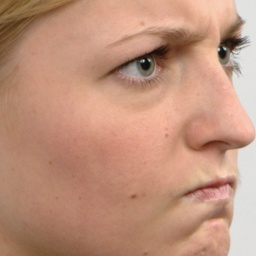

In [27]:
''' dataset의 일부 그냥 확인 '''
import matplotlib.pyplot as plt
from PIL import Image
Image.open(dataset.imgs[0][0])

In [28]:
from torch.utils import data
batch_size = 16
mode = 'train'
num_workers = 1

data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=(mode=='train'), 
                              num_workers=num_workers)

In [29]:
# RaFD만 사용할 때 celeba_loader는 꺼준다.
celeba_loader = None
rafd_loader = data_loader

In [30]:
# solver = Solver()는 그냥 지정해준 것이기 때문에 밑의 train 부터 읽는다.

import numpy as np
import torch

dataset = 'RaFD'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
c_dim = 8
# 원래 celeba에만 들어가는 거지만 논리적으로 일단 써줘야하는 것이 맞다.
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

data_iter = iter(rafd_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)

''' 함수 정의가 안되어 있을 것임 밑에 셀 먼저 실행! '''
c_fixed_list = create_labels(c_org, c_dim, dataset, selected_attrs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


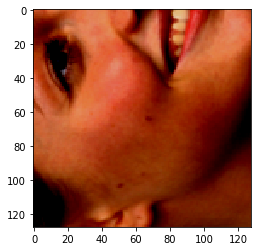

In [23]:
plt.imshow(x_fixed[7].T.cpu())

In [15]:
def create_labels(c_org, c_dim=5, dataset='CelebA', selected_attrs=None):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    if dataset == 'CelebA':
        hair_color_indices = []
        for i, attr_name in enumerate(selected_attrs):
            if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        if dataset == 'CelebA':
            c_trg = c_org.clone()
            if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
                c_trg[:, i] = 1
                for j in hair_color_indices:
                    if j != i:
                        c_trg[:, j] = 0
            else:
                c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.
        elif dataset == 'RaFD':
            c_trg = label2onehot(torch.ones(c_org.size(0))*i, c_dim)

        c_trg_list.append(c_trg.to(device))
    return c_trg_list

# 위의 creat_labels안에서 필요한 것.
def label2onehot(labels, dim):
        """Convert label indices to one-hot vectors."""
        batch_size = labels.size(0)
        out = torch.zeros(batch_size, dim)
        out[np.arange(batch_size), labels.long()] = 1
        return out

In [52]:
# Learning rate cache for decaying. 여기 부분

g_lr = 0.0001
d_lr = 0.0001

In [53]:
# Start training from scratch or resume training. 여기부분
resume_iters = None
start_iters = 0
if resume_iters:
        start_iters = resume_iters
        restore_model(resume_iters)

In [55]:
def restore_model(resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))
        G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
        
# 모델 G와 D는 아직 지정해 주지 않음.

In [28]:
num_iters = 200000
print('Start training...')
start_time = time.time()
for i in range(start_iters, num_iters):
    try:
        x_real, label_org = next(data_iter)
        ''' 여기서 잠깐, data_iter에 뭐가 들어가있는지 확인. '''

SyntaxError: unexpected EOF while parsing (<ipython-input-28-485f3c714ba0>, line 7)

In [70]:
x_real, label_org = next(data_iter)
x_real

tensor([[[[-0.6941, -0.7020, -0.7176,  ...,  0.7882,  0.7882,  0.7882],
          [-0.6863, -0.7098, -0.7255,  ...,  0.7961,  0.7961,  0.7961],
          [-0.7176, -0.7333, -0.7412,  ...,  0.7882,  0.7882,  0.7882],
          ...,
          [ 0.2235,  0.2471,  0.2471,  ...,  0.7569,  0.7569,  0.7569],
          [ 0.2392,  0.2471,  0.2471,  ...,  0.7569,  0.7569,  0.7569],
          [ 0.2471,  0.2549,  0.2549,  ...,  0.7490,  0.7569,  0.7569]],

         [[-0.7961, -0.8039, -0.8118,  ...,  0.7882,  0.7882,  0.7882],
          [-0.7882, -0.8039, -0.8118,  ...,  0.7961,  0.7961,  0.7961],
          [-0.8118, -0.8275, -0.8275,  ...,  0.7882,  0.7882,  0.7882],
          ...,
          [-0.0588, -0.0353, -0.0275,  ...,  0.7412,  0.7412,  0.7490],
          [-0.0431, -0.0275, -0.0275,  ...,  0.7412,  0.7412,  0.7490],
          [-0.0275, -0.0196, -0.0118,  ...,  0.7333,  0.7412,  0.7490]],

         [[-0.8588, -0.8667, -0.8667,  ...,  0.7882,  0.7882,  0.7882],
          [-0.8510, -0.8588, -

In [72]:
x_real.size()
label_org.size()

torch.Size([16])

In [73]:
torch.resize

AttributeError: module 'torch' has no attribute 'resize'

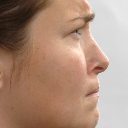

In [80]:
import matplotlib.pyplot as plt
from PIL import Image
image = Image.open(dataset.imgs[0][0])
image.resize((128,128))

## Test

In [30]:
test_iters = 200000


def test():
    """Translate images using StarGAN trained on a single dataset."""
    # Load the trained generator.
    restore_model(test_iters)

    # Set data loader.
    if dataset == 'CelebA':
        data_loader = celeba_loader
    elif dataset == 'RaFD':
        data_loader = rafd_loader

    with torch.no_grad():
        for i, (x_real, c_org) in enumerate(data_loader):

            # Prepare input images and target domain labels.
            x_real = x_real.to(device)
            c_trg_list = create_labels(c_org, c_dim, dataset, selected_attrs)

            # Translate images.
            x_fake_list = [x_real]
            for c_trg in c_trg_list:
                x_fake_list.append(G(x_real, c_trg))

            # Save the translated images.
            x_concat = torch.cat(x_fake_list, dim=3)
            result_path = os.path.join(result_dir, '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(result_path))

In [33]:
selected_attrs

['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']